## 1) Повнозв'язані нейронні мережі

In [1]:
import pandas as pd

In [3]:
df = pd.read_csv("Frogs_MFCCs.csv")
target_col = 'Family'

In [5]:
import numpy as np

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns

In [8]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [9]:
# кодування класів
le = LabelEncoder()
y = le.fit_transform(df[target_col])

num_classes = len(le.classes_)

X = df[num_cols].values

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
# розбиття на train/val/test
# відділяємо train (70%) від решти (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=56)

# розбиваємо решту (30%) навпіл: validation (15%) і test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=56)

In [12]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [16]:
# конвертація в тензори PyTorch
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

In [17]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False) 

print(f"Розміри вибірок: train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")
print(f"Розмір входу: {X_train.shape[1]}, кількість класів: {num_classes}")

Розміри вибірок: train=5036, val=1079, test=1080
Розмір входу: 23, кількість класів: 4


In [20]:
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [21]:
pl.seed_everything(56)

Seed set to 56


56

In [22]:
class FrogClassifier(pl.LightningModule):
    def __init__(self, input_dim, num_classes, learning_rate=0.001):
        super().__init__()
        self.save_hyperparameters()
        
        # архітектура мережі (feedforward NN)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),  # регуляризація
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
        
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        # логування точності
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [23]:
model = FrogClassifier(input_dim=X_train.shape[1], num_classes=num_classes)

In [24]:
# EarlyStopping зупинить навчання, якщо val_loss не покращується 5 епох
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, verbose=False, mode="min")

In [28]:
trainer = pl.Trainer(
    max_epochs=50,
    callbacks=[early_stop_callback],
    enable_progress_bar=True,
    log_every_n_steps=5
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


In [29]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | net       | Sequential       | 3.7 K  | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
3.7 K     Trainable params
0         Non-trainable params
3.7 K     Total params
0.015     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

In [30]:
model.eval()
with torch.no_grad():
    test_logits = model(torch.FloatTensor(X_test))
    test_preds_nn = torch.argmax(test_logits, dim=1).numpy()

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [32]:
nn_acc = accuracy_score(y_test, test_preds_nn)
print(f"NN accuracy: {nn_acc:.5f}")

NN accuracy: 0.99352


In [33]:
print(classification_report(y_test, test_preds_nn, target_names=le.classes_))

                 precision    recall  f1-score   support

      Bufonidae       1.00      1.00      1.00         9
  Dendrobatidae       1.00      0.99      0.99        82
        Hylidae       0.99      0.99      0.99       338
Leptodactylidae       0.99      1.00      0.99       651

       accuracy                           0.99      1080
      macro avg       1.00      0.99      0.99      1080
   weighted avg       0.99      0.99      0.99      1080



In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

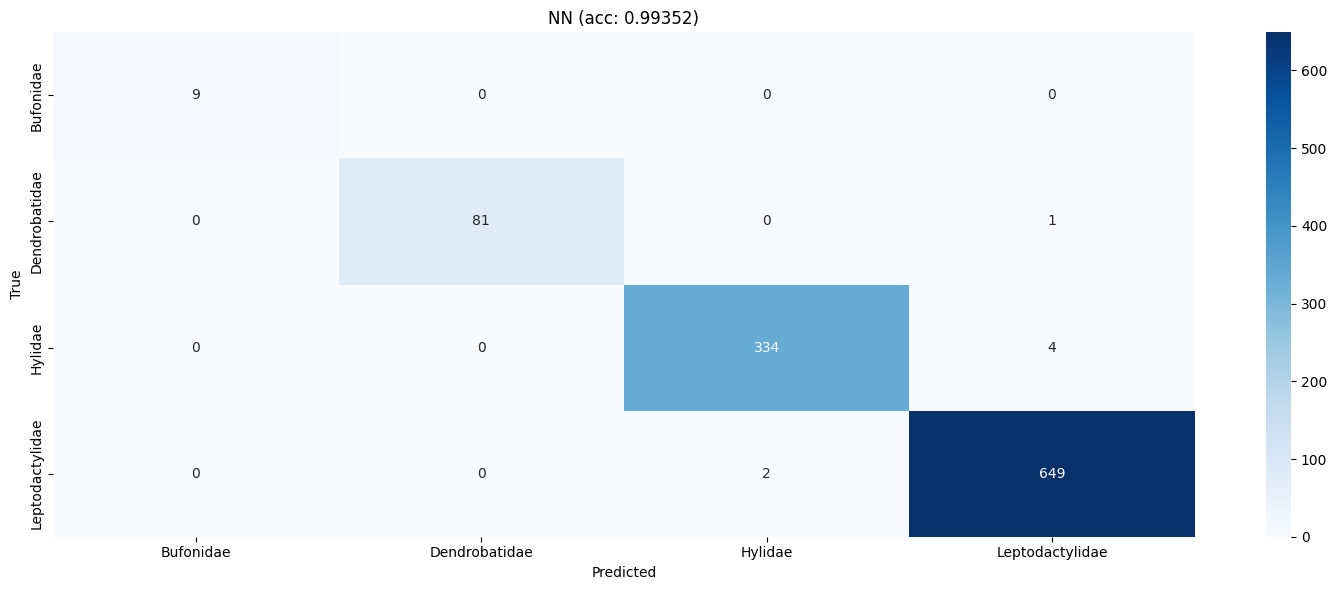

In [35]:
plt.figure(figsize=(15, 6))
sns.heatmap(confusion_matrix(y_test, test_preds_nn), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'NN (acc: {nn_acc:.5f})')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

### Порівняння з SVM з першої лабораторної
SVM виглядає трохи стабільнішим на домінуючих класах, досягаючи майже ідеальних показників. Нейромережа має незначні відхилення (0.99), що може свідчити про невелике перенавчання або потребу в довшому налаштуванні. Нейромережа краще впоралася з найскладнішим класом Bufonidae (найменша кількість прикладів), досягнувши recall 1.00. SVM тут показав свій найслабший результат (recall 0.90), сплутавши частину прикладів, але це може бути випадковістю через малу кількість тестів (support: 9 vs 10).

## 2) Згорткові нейронні мережі

In [36]:
DATA_DIR = "images"
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [39]:
from torchvision import datasets, transforms, models

In [40]:
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [41]:
full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
classes = full_dataset.classes
num_classes = len(classes)

print(f"Знайдено класи: {classes}")

Знайдено класи: ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'sheep', 'spider', 'squirrel']


In [42]:
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

In [43]:
from torch.utils.data import DataLoader, random_split

In [44]:
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

In [45]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [52]:
import torch.nn as nn
import torch.nn.functional as F

In [53]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [54]:
class TransferResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = models.resnet18(weights='DEFAULT')
        
        # заморожуємо ваги
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        # замінюємо останній шар (класифікатор) на новий
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [55]:
class ImageClassifierLit(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        self.model = model
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()
        self.save_hyperparameters(ignore=['model']) # не зберігаємо модель в hparams

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        # передаємо тільки параметри, які потребують градієнтів (для Transfer Learning)
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)

In [56]:
def train_and_evaluate(model_name, model_arch, epochs=5):
    print(f"Старт навчання {model_name}")
    
    lit_model = ImageClassifierLit(model_arch, lr=0.001)
    
    trainer = pl.Trainer(
        max_epochs=epochs,
        callbacks=[EarlyStopping(monitor="val_loss", patience=5)],
        enable_progress_bar=True,
        log_every_n_steps=5
    )
    
    trainer.fit(lit_model, train_loader, val_loader)
    
    print(f"\nОцінка {model_name} на тестових даних")
    lit_model.eval()
    lit_model.freeze()
    
    all_preds = []
    all_labels = []
    
    device = torch.device("mps")
    lit_model.to(device)
    
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = lit_model(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        
    acc = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy ({model_name}): {acc:.5f}")
    
    return acc, all_labels, all_preds

In [58]:
cnn_model = SimpleCNN(num_classes)
acc_cnn, y_true, y_pred_cnn = train_and_evaluate("Simple CNN", cnn_model, epochs=10)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | model     | SimpleCNN        | 25.7 M | train | 0    
1 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
25.7 M    Trainable params
0         Non-trainable params
25.7 M    Total params
102.877   Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode
0         Total Flops


Старт навчання Simple CNN


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]


Оцінка Simple CNN на тестових даних
Test Accuracy (Simple CNN): 0.66242


In [59]:
resnet_model = TransferResNet(num_classes)
acc_resnet, _, y_pred_resnet = train_and_evaluate("Pre-trained ResNet18", resnet_model, epochs=10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/code1715/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth



  0%|                                               | 0.00/44.7M [00:00<?, ?B/s]
  1%|▍                                      | 512k/44.7M [00:00<00:14, 3.14MB/s]
  3%|█                                     | 1.25M/44.7M [00:00<00:08, 5.22MB/s]
  4%|█▋                                    | 2.00M/44.7M [00:00<00:07, 5.91MB/s]
  6%|██▍                                   | 2.88M/44.7M [00:00<00:06, 6.80MB/s]
  8%|███▏                                  | 3.75M/44.7M [00:00<00:06, 6.59MB/s]
 10%|███▉                                  | 4.62M/44.7M [00:00<00:06, 6.64MB/s]
 12%|████▌                                 | 5.38M/44.7M [00:00<00:06, 6.68MB/s]
 14%|█████▏                                | 6.12M/44.7M [00:01<00:06, 6.34MB/s]
 16%|█████▉                                | 7.00M/44.7M [00:01<00:05, 6.60MB/s]
 17%|██████▌                               | 7.75M/44.7M [00:01<00:05, 6.80MB/s]
 19%|███████▏                              | 8.50M/44.7M [00:01<00:05, 7.01MB/s]
 21%|████████              

Старт навчання Pre-trained ResNet18


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.



Оцінка Pre-trained ResNet18 на тестових даних
Test Accuracy (Pre-trained ResNet18): 0.95901


In [61]:
print(f"Simple CNN accuracy: {acc_cnn:.5f}")
print(f"ResNet18 accuracy:   {acc_resnet:.5f}")

Simple CNN accuracy: 0.66242
ResNet18 accuracy:   0.95901


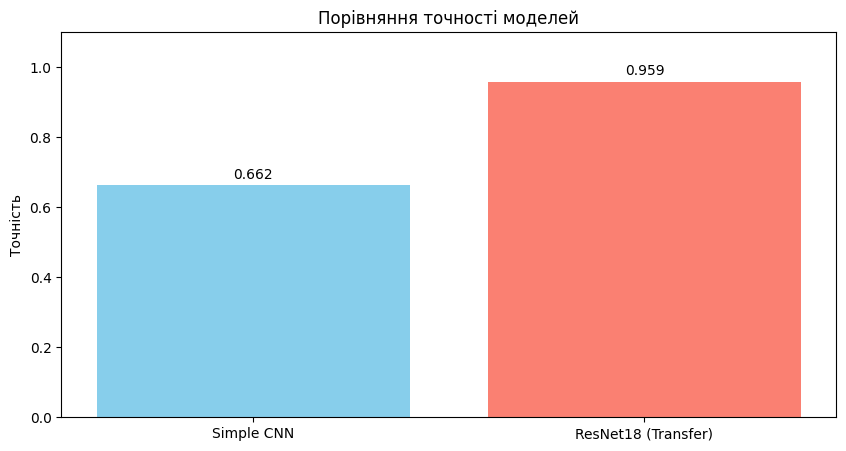

In [62]:
plt.figure(figsize=(10, 5))
bars = plt.bar(['Simple CNN', 'ResNet18 (Transfer)'], [acc_cnn, acc_resnet], color=['skyblue', 'salmon'])
plt.ylabel('Точність')
plt.title('Порівняння точності моделей')
plt.ylim(0, 1.1)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 3), ha='center', va='bottom')

plt.show()

In [63]:
print(classification_report(y_true, y_pred_resnet, target_names=classes))

              precision    recall  f1-score   support

   butterfly       0.97      0.96      0.97       312
         cat       0.94      0.97      0.95       258
     chicken       0.96      0.98      0.97       447
         cow       0.90      0.94      0.92       284
         dog       0.96      0.95      0.96       731
    elephant       0.97      0.98      0.97       189
       horse       0.95      0.94      0.95       413
       sheep       0.96      0.88      0.92       278
      spider       0.99      0.99      0.99       753
    squirrel       0.94      0.97      0.96       263

    accuracy                           0.96      3928
   macro avg       0.95      0.96      0.95      3928
weighted avg       0.96      0.96      0.96      3928



ResNet18 перемагає, тому що вона не вчиться бачити заново, а використовує попередній досвід. Це наочна демонстрація Transfer Learning. Simple CNN має лише 3 згорткові шари. Вона фізично не може побудувати складну ієрархію ознак (від ліній до частин тіла). ResNet18 має 18 глибоких шарів, що дозволяє їй будувати надзвичайно складні абстракції. Simple CNN починає навчання з абсолютно випадковими числами і їй потрібні десятки тисяч картинок, щоб просто зрозуміти, що група пікселів формує лінію, а лінії формують певний патерн. ResNet18 вже бачила 1.2 мільйона зображень. Вона вже вміє виділяти текстури, шерсть, очі та складні форми. Через ці причини ResNet18 з кастомним класифікатором демонструє значно вищу точність на обраному датасеті.

## 3) Вирішіть задачу класифікації текстів (використайте той же датасет, з яким ви працювали в лабораторній № 2) двома способами

In [64]:
import nltk
from nltk.tokenize import word_tokenize

In [65]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [77]:
sentiment_df = pd.read_csv("tweets.csv")

In [78]:
sentiment_df = sentiment_df[["airline_sentiment", "text"]]

In [79]:
from nltk.corpus import stopwords


nltk.download("stopwords", quiet=True)

True

In [80]:
import re

In [81]:
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # приведення до нижнього регістру
    text = text.lower()
    # видалення згадок користувачів (@user)
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    # видалення символів, що не є словами (пунктуація, цифри)
    text = re.sub(r'[^a-z\s]', '', text)
    # видалення зайвих пробілів
    text = re.sub(r'\s+', ' ', text).strip()
    # видалення стоп-слів
    words = text.split()
    filtered_words = [w for w in words if w not in stop_words and len(w) > 2]
    # токенізація
    tokens = word_tokenize(" ".join(filtered_words))
    return tokens

In [83]:
all_words = []
for text in sentiment_df["text"]:
    all_words.extend(preprocess_text(text))

In [84]:
from collections import Counter

In [85]:
word_counts = Counter(all_words)
# сортуємо слова за частотою
vocab = sorted(word_counts, key=word_counts.get, reverse=True)
vocab_to_int = {word: i+1 for i, word in enumerate(vocab)} # 0 - padding
vocab_size = len(vocab_to_int) + 1

print(f"Розмір словника: {vocab_size}")

Розмір словника: 13425


In [88]:
# кодування тексту в числа
seq_length = 30
features = np.zeros((len(sentiment_df), seq_length), dtype=int)

for i, text in enumerate(sentiment_df["text"]):
    tokens = preprocess_text(text)
    encoded = [vocab_to_int[word] for word in tokens if word in vocab_to_int]

    if len(encoded) == 0:
        continue
        
    # padding / truncating
    if len(encoded) <= seq_length:
        features[i, -len(encoded):] = encoded
    else:
        features[i, :] = encoded[:seq_length]

In [90]:
le = LabelEncoder()
target_encoded = le.fit_transform(sentiment_df["airline_sentiment"])

In [92]:
X = torch.tensor(features)
y = torch.tensor(target_encoded).long()

In [95]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=56)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=56)

In [96]:
BATCH_SIZE = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=BATCH_SIZE, num_workers=7, persistent_workers=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), shuffle=False, batch_size=BATCH_SIZE, num_workers=7, persistent_workers=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=False, batch_size=BATCH_SIZE, num_workers=7, persistent_workers=True)

In [98]:
from pytorch_lightning.callbacks import Callback

In [133]:
class SentimentBiLSTM(pl.LightningModule):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, 
                 embedding_matrix=None, freeze_embeddings=False, lr=0.0001):
        super().__init__()
        self.save_hyperparameters(ignore=['embedding_matrix'])
        self.lr = lr
        
        # embedding layer
        if embedding_matrix is not None:
            # (b) pre-trained GloVe initialization
            self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
            if freeze_embeddings:
                self.embedding.weight.requires_grad = False
        else:
            # (a) random initialization
            self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=0.2, batch_first=True, bidirectional=True)
        
        # fully connected layer
        self.dropout = nn.Dropout(0.2)
        # hidden_dim * 2 через bidirectional
        self.fc = nn.Linear(hidden_dim * 2, output_size)
        
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        # x: [batch_size, seq_len]
        embeds = self.embedding(x) # -> [batch_size, seq_len, embed_dim]
        
        # lstm_out: [batch_size, seq_len, hidden_dim * 2]
        lstm_out, _ = self.lstm(embeds)
        out, _ = torch.max(lstm_out, dim=1) 
        
        out = self.dropout(out)
        logits = self.fc(out)
        return logits

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(filter(lambda p: p.requires_grad, self.parameters()), lr=self.lr)

# callback для збору метрик
class MetricTracker(Callback):
    def __init__(self):
        self.history = {'loss': [], 'val_acc': []}
    
    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get('train_loss')
        acc = trainer.callback_metrics.get('val_acc')
        if loss: self.history['loss'].append(loss.item())
        if acc: self.history['val_acc'].append(acc.item())

In [101]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip

In [102]:
!unzip -q glove.6B.zip

In [106]:
def load_glove_from_file(filename, vocab_to_int, embed_dim):
    embeddings_index = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    
    # створення матриці для нашого словника
    embedding_matrix = np.zeros((len(vocab_to_int) + 1, embed_dim))
    hits = 0
    misses = 0
    
    for word, i in vocab_to_int.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            # якщо слова немає в GloVe, ініціалізуємо випадково
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embed_dim, ))
            misses += 1
            
    print(f"Слова знайдені в GloVe: {hits}")
    print(f"Слова відсутні в GloVe: {misses}")
    
    return embedding_matrix

In [134]:
GLOVE_FILE = 'glove.6B.100d.txt'
embed_dim = 100 
hidden_dim = 128
n_layers = 2
output_size = len(le.classes_)
EPOCHS = 30

In [135]:
import time
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [136]:
def train_experiment(name, embedding_matrix=None, freeze=False):
    print(f"\nStart experiment: {name}")
    model = SentimentBiLSTM(vocab_size, output_size, embed_dim, hidden_dim, n_layers,
                            embedding_matrix=embedding_matrix, freeze_embeddings=freeze)
    
    tracker = MetricTracker()
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        callbacks=[EarlyStopping(monitor="val_loss", patience=5), tracker],
        enable_progress_bar=True,
        log_every_n_steps=5
    )
    
    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    duration = time.time() - start_time
    
    trainer.test(model, test_loader)
    
    model.eval()
    model.freeze()
    
    all_preds = []
    all_labels = []
    device = model.device 

    with torch.no_grad():
        for batch in test_loader:
            x, y_batch = batch
            x, y_batch = x.to(device), y_batch.to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    
    print(f"\nClassification report ({name}):")
    print(classification_report(all_labels, all_preds, target_names=le.classes_))
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    final_acc = accuracy_score(all_labels, all_preds)
    return final_acc, tracker.history, duration

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | embedding | Embedding        | 1.3 M  | train | 0    
1 | lstm      | LSTM             | 630 K  | train | 0    
2 | dropout   | Dropout          | 0      | train | 0    
3 | fc        | Linear           | 771    | train | 0    
4 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
7.896     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
0         Total Flops



Start experiment: Random Embeddings


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7326958179473877
        test_loss           0.6747007966041565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Classification report (Random Embeddings):
              precision    recall  f1-score   support

    negative       0.87      0.78      0.82      1345
     neutral       0.51      0.65      0.58       477
    positive       0.66      0.67      0.67       374

    accuracy                           0.73      2196
   macro avg       0.68      0.70      0.69      2196
weighted avg       0.75      0.73      0.74      2196



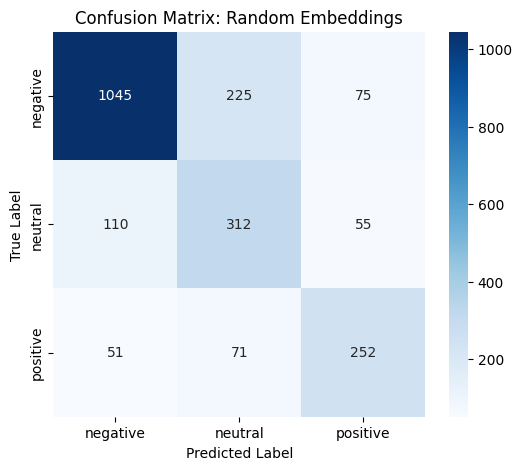

In [137]:
acc_rand, hist_rand, time_rand = train_experiment("Random Embeddings")

In [120]:
glove_matrix = load_glove_from_file(GLOVE_FILE, vocab_to_int, embed_dim)

Слова знайдені в GloVe: 8725
Слова відсутні в GloVe: 4699


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores

  | Name      | Type             | Params | Mode  | FLOPs
---------------------------------------------------------------
0 | embedding | Embedding        | 1.3 M  | train | 0    
1 | lstm      | LSTM             | 630 K  | train | 0    
2 | dropout   | Dropout          | 0      | train | 0    
3 | fc        | Linear           | 771    | train | 0    
4 | criterion | CrossEntropyLoss | 0      | train | 0    
---------------------------------------------------------------
631 K     Trainable params
1.3 M     Non-trainable params
2.0 M     Total params
7.896     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode
0         Total Flops



Start experiment: GloVe Embeddings


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Testing: |                                                | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7795992493629456
        test_loss           0.5604086518287659
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Classification report (GloVe Embeddings):
              precision    recall  f1-score   support

    negative       0.82      0.90      0.86      1345
     neutral       0.66      0.52      0.58       477
    positive       0.74      0.70      0.72       374

    accuracy                           0.78      2196
   macro avg       0.74      0.70      0.72      2196
weighted avg       0.77      0.78      0.77      2196



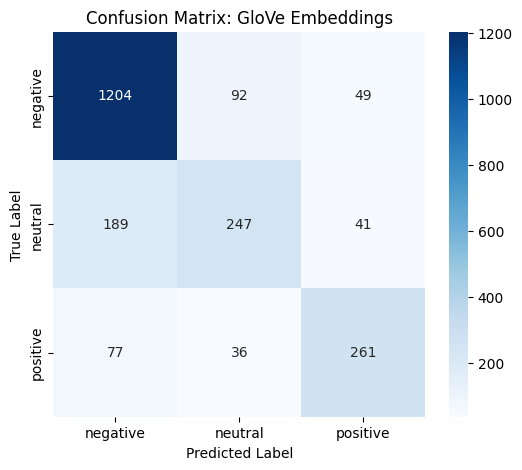

In [138]:
acc_glove, hist_glove, time_glove = train_experiment("GloVe Embeddings", embedding_matrix=glove_matrix, freeze=True)

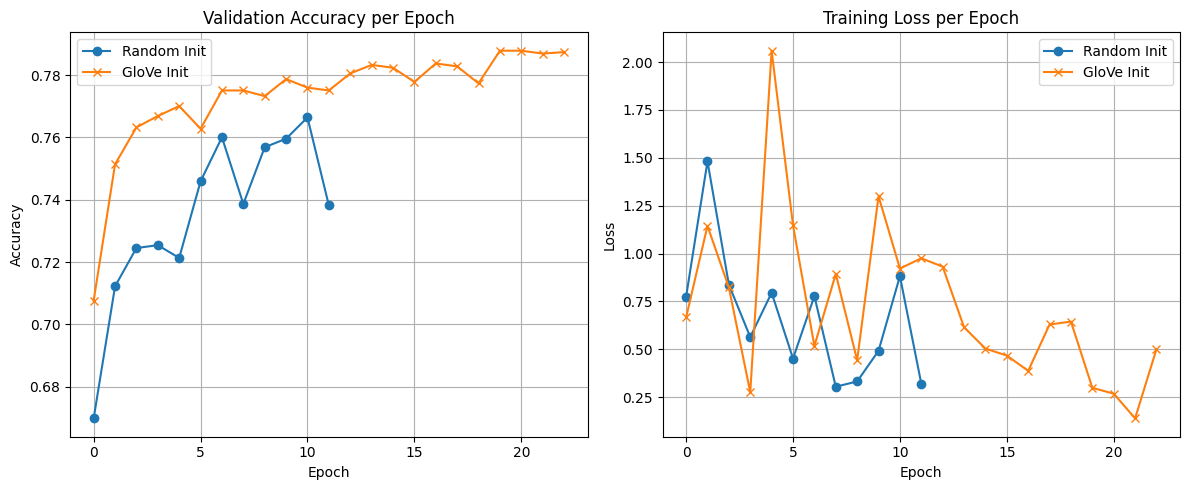

In [139]:
plt.figure(figsize=(12, 5))

# графік точності
plt.subplot(1, 2, 1)
plt.plot(hist_rand['val_acc'], label='Random Init', marker='o')
plt.plot(hist_glove['val_acc'], label='GloVe Init', marker='x')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# графік лосу
plt.subplot(1, 2, 2)
plt.plot(hist_rand['loss'], label='Random Init', marker='o')
plt.plot(hist_glove['loss'], label='GloVe Init', marker='x')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [140]:
print(f"{'Random Init':<20} | {acc_rand:.5f}          | {time_rand:.5f}s")
print(f"{'GloVe Init':<20} | {acc_glove:.5f}          | {time_glove:.5f}s")

Random Init          | 0.73270          | 69.66474s
GloVe Init           | 0.77960          | 111.35702s


GloVe стартує з вищої точки (71%) порівняно з Random (67%). Це тому, що модель вже знає слова. GloVe досягає вищої максимальної точності (79%), тоді як Random застряг на 76%. 

Синя лінія обривається на 12-й епосі. Це спрацював Early Stopping. Це означає, що модель з випадковою ініціалізацією перестала покращуватися і почала перенавчатися набагато раніше. Модель з GloVe продовжувала вчитися до 22-ї епохи, знаходячи нові патерни.

Цей результат підтверджує гіпотезу завдання: використання Pre-trained Embeddings (GloVe) покращує якість класифікації та прискорює навчання, особливо на невеликих наборах даних.